# 讀取評論資料和欄位處理

In [1]:
# read json file

import json
import pandas as pd

with open('./Employee Review about their organization.json') as file:
    contents = file.read()
    contents = eval(contents)
    
df_list = []
for i in range(len(contents)):
    row_list = []
    row = contents[i]
    row_list.append(row["ReviewTitle"])
    row_list.append(row["CompleteReview"])
    row_list.append(row["URL"])
    row_list.append(row["Rating"])
    row_list.append(row["ReviewDetails"])
    df_list.append(row_list)
    
df = pd.DataFrame(data = df_list, columns = ['ReviewTitle', 'CompleteReview', 'URL', 'Rating', 'ReviewDetails'])

In [2]:
# 欄位處理

df['Company'] = df.URL.str.split('/')[:].str[4]
df['isCurrentEmployee'] = df.ReviewDetails.apply(lambda x: 0 if 'Former Employee' in x else 1)
rating = df.pop('Rating')
df['Rating'] = rating
df.drop(columns = ['URL', 'ReviewDetails'], inplace = True)
df.head()

,ReviewTitle,CompleteReview,Company,isCurrentEmployee,Rating
0,Productive,"Good company, cool workplace, work load little...",Reliance-Industries-Ltd,1,3.0
1,Stressful,1. Need to work on boss's whims and fancies 2....,Reliance-Industries-Ltd,0,3.0
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",Reliance-Industries-Ltd,0,5.0
3,Productive,I am just pass out bsc in chemistry Typical da...,Reliance-Industries-Ltd,1,5.0
4,Non productive,Not so fun at work just blame games Target pe...,Reliance-Industries-Ltd,0,1.0


In [3]:
# 有 14 多萬筆評論
len(df)

145209

In [4]:
df['Rating'] = df['Rating'].astype(float)
df['Rating'].mean()

4.053660585776364

In [5]:
mean = df['Rating'].mean()
df['Rating'].iloc[df['Rating'] < mean] = 0
df['Rating'].iloc[df['Rating'] >= mean] = 1

C:\Users\ChenPoYen\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [6]:
df['Rating']

0         0.0
1         0.0
2         1.0
3         1.0
4         0.0
         ... 
145204    0.0
145205    0.0
145206    0.0
145207    0.0
145208    1.0
Name: Rating, Length: 145209, dtype: float64

In [7]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

#先抽 1 %
X_other, X_train, y_other, y_train = train_test_split(X, y, test_size = 0.01, random_state = 8, stratify = y)

In [8]:
len(X_train)

1453

In [9]:
X_train['id'] = X_train.index
X_train

,ReviewTitle,CompleteReview,Company,isCurrentEmployee,id
8807,Fun Place to work and show case your skills,It's one of the best startups to work with !!\...,Ride.swiggy,1,8807
96887,Good Experience,I had a great experience working in IBM. Got e...,IBM,0,96887
65942,working profile,Pros\r Excellent work - life balance.\r Great ...,Wells-Fargo,1,65942
77935,fun to work,generating the leads\r learned how to deal wit...,Kotak-Mahindra-Bank,0,77935
88788,Kinda ok kinda not,Depends greatly on the team you go to.\r If yo...,Amazon.com,0,88788
...,...,...,...,...,...
27259,Working atmosphere and usage of modern technol...,Reliance industries is well equipped with mode...,Reliance-Industries-Ltd,0,27259
129899,Nice company to start your career,This company not only helped in learning but p...,Accenture,1,129899
120979,Good Organization,IBM is a very good organization. It is built i...,IBM,0,120979
142370,Fun-filled working environment with plenty of ...,A typical day at TCS used to be like going to ...,Tata-Consultancy-Services-(tcs),0,142370


# 文本前處理

In [10]:
#沿用 PA1 的內容
def syllables(word):
    #當字尾是e時音節數會減一
    if word.endswith("e"):
        word.replace("e", "")
    
    #當字裡包含a e i o u y時，會增加音節
    word = word.replace("a", ",")
    word = word.replace("e", ",")
    word = word.replace("i", ",")
    word = word.replace("o", ",")
    word = word.replace("u", ",")
    word = word.replace("y", ",")
    
    count = word.count(",")
    return count

In [11]:
#沿用 PA1 的內容
def tokenization(text):
    punctuation = [",", "'", ".", "?", "!", "(", ")", ":", "`", "``", "%", "{", "}", ";", "*", "#", "+", "$", 
                   "\\", "/", "_", "=", "^", "&", "<", ">", "@", "|", "[", "]"]
    for i in punctuation:
        text = text.replace(i, " ")
    
    #新增移除數字
    numbers = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "0"]
    for j in numbers:
        text = text.replace(j, " ")
    
    text = text.replace("\n", " ")
    text = text.replace("\t", " ") 
    text = text.replace("\r", " ") 
    text = text.replace('"', "")
    
    #檢查 hyphens
    if "-" in text:
        t = text.count("-")
        
        #如果那個字的 hyphen 數小於2時，就會進入音節數的判斷
        if t < 2:
            count_syllables_word = text.split("-")
            s = syllables(count_syllables_word[0]) #計算第一個字音節
            
            #如果那個字的音節數小於2時，就會把字合併
            if(s < 2): 
                text = text.replace("-", "") #ex. co-worker --> coworker  
            else:
                text = text.replace("-", " ") #ex. semi-supervised --> semi supervised
        else:
            text = text.replace("-", " ") #ex. state-of-art --> state of art

    
    text = text.split(" ")
    text = list(filter(None, text)) #remove null
    
    return text

In [12]:
from nltk.stem.porter import *
import nltk
from nltk.corpus import stopwords
stemmer = PorterStemmer()
stopword_list = set(stopwords.words('english'))

docID = []
t_index = []
term = []
df = []
tf = []

for i in range(len(X_train)):
    token_list = []    

    token_list.extend(tokenization(X_train['CompleteReview'].iloc[i].encode('utf-8', 'ignore').decode('ascii', 'ignore')))
    
    #lower case
    for j in range (len(token_list)):
        if(isinstance(token_list[j], str)): #only string has to lower case 
            token_list[j] = token_list[j].lower()  
    
    #stemming
#     new_token_list = [stemmer.stem(token) for token in token_list]    
    
    #stopword removal
    filtered_tokens = [token for token in token_list if token not in stopword_list] 
    
    #remove strange token
    filtered_tokens = [token for token in filtered_tokens if token != 'zzcadasdgadsgadgdddaddddddgggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg']
    
    #紀錄 doc_i 中的 docID, term, tf
    for t in filtered_tokens: 
        docID.append(X_train['id'].iloc[i])
        term.append(t)
        tf.append(filtered_tokens.count(t)) #tf 的平均是用原始檔案中的字數去除

In [13]:
#step_one: 在這個步驟中將 term 跟 docID 取出
step_one = []
for i in range(len(term)):
    tmp = [term[i], str(docID[i])] #[apple, 1]
    step_one.append(tmp)

In [14]:
#step_two: 這個步驟中將 term 按照字母順序排列，並去除重複的字及記錄 df

import numpy as np
#sort alphabetically
step_two = sorted(step_one, key=lambda l:l[0])

step_two = np.array(step_two) #list to numpy

step_two = np.unique(step_two, axis=0) #去除同一個 docID 中的相同字
step_two = step_two.T
t, df = np.unique(step_two[0], return_counts=True) #計算不同檔案中的相同字數量
print(t)
print(df)

['abide' 'abilities' 'ability' ... 'yrs' 'zeal' 'zonal']
[1 2 9 ... 3 1 1]


In [15]:
my_dic ={}
my_dic["term"] = t
my_dic["df"] = df
my_dic["t_index"] = [i for i in range (1, len(t)+1)] #給定 term index (從1開始)

In [16]:
#把字典的字和對應到的文件 id 取出，方便之後找字對應到的 class
dict_ids = {}
c = 0
for t in step_two[0]:
    if t in term:
        if t not in dict_ids:
            dict_ids[t] = list()
        dict_ids[t].append(step_two[1,c])      
        
    c+=1

In [17]:
#寫入 dictionary.txt 中
dic = open("dictionary.txt", "w")
dic.write("t_index term df")
for i in range (len(my_dic["term"])):
    dic.write("\n" + str(my_dic["t_index"][i]).encode('utf-8','ignore').decode("utf-8") + " " + str(my_dic["term"][i]).encode('utf-8','ignore').decode("utf-8") + " " + str(my_dic["df"][i]).encode('utf-8','ignore').decode("utf-8"))
    
dic.close()

In [18]:
#將 docID, term, tf, t_index, df 放到同一個 dataframe，以方便計算 tf-idf
#dataframe for tf
import pandas as pd
tf_dataframe = pd.DataFrame(list(zip(docID, term, tf)), columns =['docID', 'term', 'tf'])

In [19]:
tf_dataframe

,docID,term,tf
0,8807,one,1
1,8807,best,6
2,8807,startups,1
3,8807,work,5
4,8807,good,1
...,...,...,...
30630,23390,employees,1
30631,23390,experience,1
30632,23390,good,3
30633,23390,working,1


In [20]:
#dataframe for dictionary
dict_df = pd.read_csv('dictionary.txt', delimiter = " ", keep_default_na=False)

In [21]:
#join tf_dataframe with dataframes
df3 = tf_dataframe.join(dict_df.set_index('term'), on='term')

In [22]:
df3

,docID,term,tf,t_index,df
0,8807,one,1,2862,120
1,8807,best,6,434,154
2,8807,startups,1,3910,1
3,8807,work,5,4512,868
4,8807,good,1,1814,734
...,...,...,...,...,...
30630,23390,employees,1,1318,139
30631,23390,experience,1,1513,209
30632,23390,good,3,1814,734
30633,23390,working,1,4521,295


In [23]:
#先計算 tf-idf
N = len(X_train)
tfidf = df3['tf'] * np.log10(N / df3['df'])
df3 = df3.assign(tf_idf = tfidf)

In [24]:
#將 tf-idf 轉為 unit vector
new_df3 = df3.copy()
for i in (X_train['id']):
    #完整 vector space 大小
    matrix = df3.shape[0]   
    vector_space = np.zeros(matrix)
    rows = df3.loc[df3['docID'] == i]
    
    #取出對應的 docID 的 vector 後算距離
    vector_space[rows['t_index']] = rows['tf_idf']
    new_tfidf = rows.iloc[:, 5] / np.linalg.norm(vector_space)
    
    #改成 unit vector
    new_df3.loc[new_df3['docID'] == i, 'tf_idf'] = new_tfidf

In [25]:
new_df3

,docID,term,tf,t_index,df,tf_idf
0,8807,one,1,2862,120,0.085904
1,8807,best,6,434,154,0.463868
2,8807,startups,1,3910,1,0.250813
3,8807,work,5,4512,868,0.088731
4,8807,good,1,1814,734,0.023522
...,...,...,...,...,...,...
30630,23390,employees,1,1318,139,0.168582
30631,23390,experience,1,1513,209,0.139285
30632,23390,good,3,1814,734,0.147156
30633,23390,working,1,4521,295,0.114529


# Normalized TF-IDF DataFrame 整理

In [26]:
# 字典的字
terms = sorted(set(new_df3['term']))
len(terms)

4559

In [27]:
# 評論 ID
doc_IDs = sorted(set(new_df3['docID']))
len(doc_IDs)

1453

In [28]:
# 轉成 normalized TF-IDF matrix

normalized_TFIDF_matrix = pd.DataFrame(columns = terms, index = doc_IDs)

for i in doc_IDs:
    
    terms_of_docID = new_df3[new_df3['docID'] == i].term.values
    
    for t in terms:
        if t not in terms_of_docID:
            normalized_TFIDF_matrix.at[i, t] = 0.
        else:
            normalized_TFIDF_matrix.at[i, t] = new_df3[(new_df3['docID'] == i) & (new_df3['term'] == t)].tf_idf.values[0]

normalized_TFIDF_matrix

,abide,abilities,ability,able,abled,abroad,absence,absenteeism,absolutely,abt,...,years,yes,yet,yoga,yoir,young,youve,yrs,zeal,zonal
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.492356,0.0,0.0
144924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 找評論面向：分群

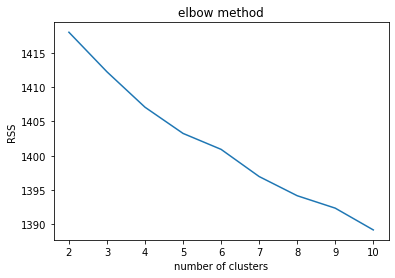

In [29]:
# find number of clusters：elbow (knees) method (K-means)

import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

cluster_numbers = [2, 3, 4, 5, 6, 7, 8, 9, 10]
RSS = []

for k in cluster_numbers:
    kmeans = KMeans(n_clusters = k, random_state = 5).fit(normalized_TFIDF_matrix.values)
    RSS.append(kmeans.inertia_)

plt.plot(cluster_numbers, RSS)
plt.xlabel('number of clusters')
plt.ylabel('RSS')
plt.title('elbow method')
plt.show()

In [30]:
# K-means clustering (10 個 topic)

clusters = {}
kmeans = KMeans(n_clusters = 10, random_state = 5).fit(normalized_TFIDF_matrix.values)
cluster_results = kmeans.labels_

In [31]:
for cluster in set(cluster_results):
    members = []
    for i in range(len(cluster_results)):
        if cluster_results[i] == cluster:
            members.append(doc_IDs[i])
    clusters[cluster] = members

In [32]:
# feature selection (to understand the cluster(topic) through important terms)

# pointwise mutual information

def term_count_PMI(counttc, ptc, pt, pc):
    PMI = np.log2(ptc / (pt * pc))
    return counttc * PMI

cluster_terms = {}

for cluster in clusters:
    
    scores = []
    
    # calculate probability of cluster
    pc = len(clusters[cluster]) / len(doc_IDs)
    
    for t in terms:
        
        # calculate count of term t in cluster
        counttc = 0
        for member in clusters[cluster]:
            terms_of_member = new_df3[new_df3['docID'] == member].term.values
            if t in terms_of_member:
                counttc += new_df3[(new_df3['docID'] == member) & (new_df3['term'] == t)].tf.values[0]
        
        if counttc == 0:
            scores.append(0)
        
        else:
            
            # calculate probability of term t in cluster
            ptc = 0
            n = 0
            for member in clusters[cluster]:
                if t in new_df3[new_df3['docID'] == member].term.values:
                    n += 1
            ptc = n/len(doc_IDs)

            # calculate probability of term t
            pt = len(set(new_df3[new_df3['term'] == t].docID.values)) / len(doc_IDs)

            # calcuate count * PMI
            scores.append(term_count_PMI(counttc, ptc, pt, pc))
    
    # find 10 terms with largest score
    cluster_terms[cluster] = [terms[i] for i in np.argsort(scores)[-10:]]

In [33]:
for topic in cluster_terms:
    print('Topic ' + str(topic) + ':')
    print(cluster_terms[topic], '\n')

Topic 0:
['hike', 'salary', 'career', 'security', 'growth', 'excellent', 'good', 'work', 'life', 'balance'] 

Topic 1:
['usa', 'press', 'cost', 'writing', 'claims', 'time', 'tasks', 'thing', 'needs', 'accenture'] 

Topic 2:
['typical', 'management', 'learned', 'hardest', 'job', 'day', 'enjoyable', 'workers', 'co', 'part'] 

Topic 3:
['company', 'training', 'oracle', 'new', 'got', 'one', 'learn', 'opportunity', 'technology', 'best'] 

Topic 4:
['endeavors', 'feedback', 'experience', 'us', 'glad', 'hear', 'thank', 'hi', 'wish', 'hgs'] 

Topic 5:
['enjoy', 'place', 'location', 'hard', 'work', 'good', 'environment', 'working', 'fun', 'nice'] 

Topic 6:
['deloitte', 'global', 'exposure', 'life', 'balance', 'learning', 'opportunities', 'work', 'place', 'great'] 

Topic 7:
['good', 'hdfc', 'working', 'bank', 'learn', 'many', 'new', 'lot', 'learned', 'things'] 

Topic 8:
['various', 'low', 'support', 'target', 'managing', 'market', 'members', 'level', 'ibm', 'team'] 

Topic 9:
['processing', '

In [77]:
# K-means clustering (5 個 topic)

clusters = {}
kmeans = KMeans(n_clusters = 5, random_state = 5).fit(normalized_TFIDF_matrix.values)
cluster_results = kmeans.labels_

In [78]:
for cluster in set(cluster_results):
    members = []
    for i in range(len(cluster_results)):
        if cluster_results[i] == cluster:
            members.append(doc_IDs[i])
    clusters[cluster] = members

In [79]:
# feature selection (to understand the cluster(topic) through important terms)

# pointwise mutual information

def term_count_PMI(counttc, ptc, pt, pc):
    PMI = np.log2(ptc / (pt * pc))
    return counttc * PMI

cluster_terms = {}

for cluster in clusters:
    
    scores = []
    
    # calculate probability of cluster
    pc = len(clusters[cluster]) / len(doc_IDs)
    
    for t in terms:
        
        # calculate count of term t in cluster
        counttc = 0
        for member in clusters[cluster]:
            terms_of_member = new_df3[new_df3['docID'] == member].term.values
            if t in terms_of_member:
                counttc += new_df3[(new_df3['docID'] == member) & (new_df3['term'] == t)].tf.values[0]
        
        if counttc == 0:
            scores.append(0)
        
        else:
            
            # calculate probability of term t in cluster
            ptc = 0
            n = 0
            for member in clusters[cluster]:
                if t in new_df3[new_df3['docID'] == member].term.values:
                    n += 1
            ptc = n/len(doc_IDs)

            # calculate probability of term t
            pt = len(set(new_df3[new_df3['term'] == t].docID.values)) / len(doc_IDs)

            # calcuate count * PMI
            scores.append(term_count_PMI(counttc, ptc, pt, pc))
    
    # find 10 terms with largest score
    cluster_terms[cluster] = [terms[i] for i in np.argsort(scores)[-10:]]

In [80]:
for topic in cluster_terms:
    print('Topic ' + str(topic) + ':')
    print(cluster_terms[topic], '\n')

Topic 0:
['exposure', 'projects', 'growth', 'opportunities', 'good', 'place', 'work', 'great', 'life', 'balance'] 

Topic 1:
['experience', 'skills', 'hgs', 'work', 'working', 'best', 'place', 'nice', 'environment', 'good'] 

Topic 2:
['lot', 'challenges', 'technology', 'everyday', 'learning', 'day', 'technologies', 'things', 'learn', 'new'] 

Topic 3:
['typical', 'management', 'learned', 'day', 'job', 'hardest', 'enjoyable', 'part', 'workers', 'co'] 

Topic 4:
['worked', 'products', 'hr', 'much', 'services', 'employee', 'quality', 'project', 'bank', 'process'] 



# 找評論面向：DBSCAN

# min_samples=7

In [42]:
# 轉成 TF 向量

TF_matrix = pd.DataFrame(columns = terms, index = doc_IDs)

for i in doc_IDs:
    
    terms_of_docID = new_df3[new_df3['docID'] == i].term.values
    
    for t in terms:
        if t not in terms_of_docID:
            TF_matrix.at[i, t] = 0
        else:
            TF_matrix.at[i, t] = new_df3[(new_df3['docID'] == i) & (new_df3['term'] == t)].tf.values[0]

In [43]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(metric='euclidean', eps=1.2, min_samples=7)
dbscan.fit(normalized_TFIDF_matrix.values)

DBSCAN(eps=1.2, min_samples=7)

In [44]:
dbscan.labels_

array([-1, -1, -1, ..., -1,  2,  1], dtype=int64)

In [45]:
from collections import Counter
print(Counter(dbscan.labels_))

Counter({-1: 1321, 1: 37, 2: 20, 4: 18, 3: 14, 7: 12, 6: 11, 0: 7, 8: 7, 5: 6})


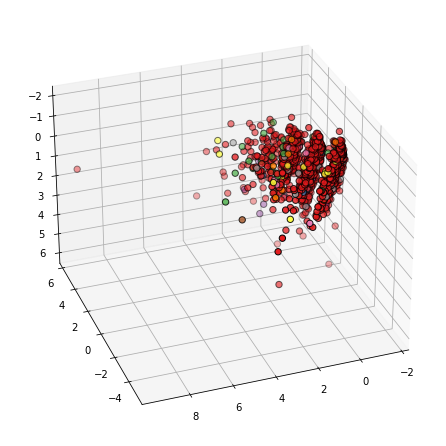

In [46]:
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.decomposition import PCA   #降維度   

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(TF_matrix.values)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=dbscan.labels_,
          cmap=plt.cm.Set1, edgecolor='k', s=40)

In [47]:
cluster_results = dbscan.labels_
for cluster in set(cluster_results):
    members = []
    for i in range(len(cluster_results)):
        if cluster_results[i] == cluster:
            members.append(doc_IDs[i])
    clusters[cluster] = members

In [48]:
# feature selection (to understand the cluster(topic) through important terms)

# pointwise mutual information

def term_count_PMI(counttc, ptc, pt, pc):
    PMI = np.log2(ptc / (pt * pc))
    return counttc * PMI

cluster_terms = {}

for cluster in clusters:
    
    scores = []
    
    # calculate probability of cluster
    pc = len(clusters[cluster]) / len(doc_IDs)
    
    for t in terms:
        
        # calculate count of term t in cluster
        counttc = 0
        for member in clusters[cluster]:
            terms_of_member = new_df3[new_df3['docID'] == member].term.values
            if t in terms_of_member:
                counttc += new_df3[(new_df3['docID'] == member) & (new_df3['term'] == t)].tf.values[0]
        
        if counttc == 0:
            scores.append(0)
        
        else:
            
            # calculate probability of term t in cluster
            ptc = 0
            n = 0
            for member in clusters[cluster]:
                if t in new_df3[new_df3['docID'] == member].term.values:
                    n += 1
            ptc = n/len(doc_IDs)

            # calculate probability of term t
            pt = len(set(new_df3[new_df3['term'] == t].docID.values)) / len(doc_IDs)

            # calcuate count * PMI
            scores.append(term_count_PMI(counttc, ptc, pt, pc))
    
    # find 10 terms with largest score
    cluster_terms[cluster] = [terms[i] for i in np.argsort(scores)[-10:]]

In [49]:
for topic in cluster_terms:
    print('Topic ' + str(topic) + ':')
    print(cluster_terms[topic], '\n')

Topic 0:
['programmed', 'enable', 'lovable', 'across', 'glad', 'employees', 'know', 'enjoyed', 'thanks', 'sutherland'] 

Topic 1:
['exposure', 'slow', 'career', 'assignments', 'good', 'work', 'growth', 'opportunities', 'place', 'great'] 

Topic 2:
['every', 'learned', 'hardest', 'typical', 'day', 'workers', 'job', 'co', 'enjoyable', 'part'] 

Topic 3:
['captive', 'freely', 'native', 'things', 'pleasure', 'good', 'overall', 'company', 'learned', 'lot'] 

Topic 4:
['success', 'feedback', 'experience', 'us', 'hear', 'glad', 'thank', 'hi', 'wish', 'hgs'] 

Topic 5:
['allowances', 'execution', 'guaranteed', 'standards', 'good', 'life', 'job', 'balance', 'security', 'maintained'] 

Topic 6:
['bhubaneswar', 'working', 'give', 'friendly', 'environment', 'place', 'people', 'good', 'staff', 'nice'] 

Topic 7:
['ltd', 'bonus', 'proud', 'things', 'loans', 'also', 'well', 'banks', 'hdfc', 'bank'] 

Topic 8:
['fight', 'projects', 'balance', 'salary', 'available', 'work', 'option', 'ibm', 'home', 'hi

# min_samples=8

In [50]:
dbscan = DBSCAN(metric='euclidean', eps=1.2, min_samples=8)
dbscan.fit(normalized_TFIDF_matrix.values)

DBSCAN(eps=1.2, min_samples=8)

In [51]:
dbscan.labels_

array([-1, -1, -1, ..., -1,  1,  0], dtype=int64)

In [52]:
from collections import Counter
print(Counter(dbscan.labels_))

Counter({-1: 1347, 0: 29, 1: 20, 3: 18, 6: 12, 5: 11, 2: 10, 4: 6})


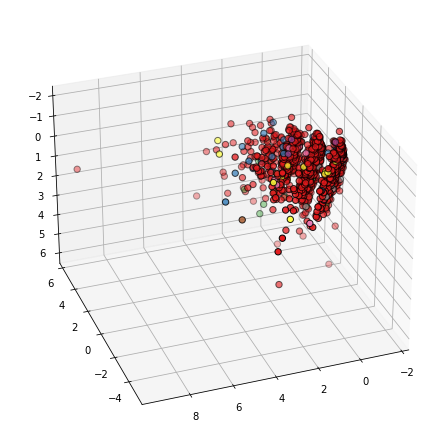

In [53]:
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.decomposition import PCA   #降維度   

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(TF_matrix.values)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=dbscan.labels_,
          cmap=plt.cm.Set1, edgecolor='k', s=40)

In [54]:
cluster_results = dbscan.labels_
for cluster in set(cluster_results):
    members = []
    for i in range(len(cluster_results)):
        if cluster_results[i] == cluster:
            members.append(doc_IDs[i])
    clusters[cluster] = members

In [55]:
# feature selection (to understand the cluster(topic) through important terms)

# pointwise mutual information

def term_count_PMI(counttc, ptc, pt, pc):
    PMI = np.log2(ptc / (pt * pc))
    return counttc * PMI

cluster_terms = {}

for cluster in clusters:
    
    scores = []
    
    # calculate probability of cluster
    pc = len(clusters[cluster]) / len(doc_IDs)
    
    for t in terms:
        
        # calculate count of term t in cluster
        counttc = 0
        for member in clusters[cluster]:
            terms_of_member = new_df3[new_df3['docID'] == member].term.values
            if t in terms_of_member:
                counttc += new_df3[(new_df3['docID'] == member) & (new_df3['term'] == t)].tf.values[0]
        
        if counttc == 0:
            scores.append(0)
        
        else:
            
            # calculate probability of term t in cluster
            ptc = 0
            n = 0
            for member in clusters[cluster]:
                if t in new_df3[new_df3['docID'] == member].term.values:
                    n += 1
            ptc = n/len(doc_IDs)

            # calculate probability of term t
            pt = len(set(new_df3[new_df3['term'] == t].docID.values)) / len(doc_IDs)

            # calcuate count * PMI
            scores.append(term_count_PMI(counttc, ptc, pt, pc))
    
    # find 10 terms with largest score
    cluster_terms[cluster] = [terms[i] for i in np.argsort(scores)[-10:]]

In [56]:
for topic in cluster_terms:
    print('Topic ' + str(topic) + ':')
    print(cluster_terms[topic], '\n')

Topic 0:
['security', 'culture', 'grow', 'career', 'growth', 'work', 'good', 'opportunities', 'place', 'great'] 

Topic 1:
['every', 'learned', 'hardest', 'typical', 'day', 'workers', 'job', 'co', 'enjoyable', 'part'] 

Topic 2:
['culture', 'wants', 'carrer', 'captive', 'freely', 'things', 'pleasure', 'company', 'lot', 'learned'] 

Topic 3:
['success', 'feedback', 'experience', 'us', 'hear', 'glad', 'thank', 'hi', 'wish', 'hgs'] 

Topic 4:
['allowances', 'execution', 'guaranteed', 'standards', 'good', 'life', 'job', 'balance', 'security', 'maintained'] 

Topic 5:
['bhubaneswar', 'working', 'give', 'friendly', 'environment', 'place', 'people', 'good', 'staff', 'nice'] 

Topic 6:
['ltd', 'bonus', 'proud', 'things', 'loans', 'also', 'well', 'banks', 'hdfc', 'bank'] 

Topic 7:
['ltd', 'bonus', 'proud', 'things', 'loans', 'also', 'well', 'banks', 'hdfc', 'bank'] 

Topic 8:
['fight', 'projects', 'balance', 'salary', 'available', 'work', 'option', 'ibm', 'home', 'hike'] 

Topic 9:
['processin

# eps=1.25, min_samples=3

In [57]:
dbscan = DBSCAN(metric='euclidean', eps=1.25, min_samples=3)
dbscan.fit(normalized_TFIDF_matrix.values)

DBSCAN(eps=1.25, min_samples=3)

In [58]:
dbscan.labels_

array([ 0, -1,  0, ...,  0,  0,  0], dtype=int64)

In [59]:
from collections import Counter
print(Counter(dbscan.labels_))

Counter({0: 733, -1: 687, 1: 4, 10: 4, 3: 4, 8: 3, 7: 3, 4: 3, 9: 3, 2: 3, 5: 3, 6: 3})


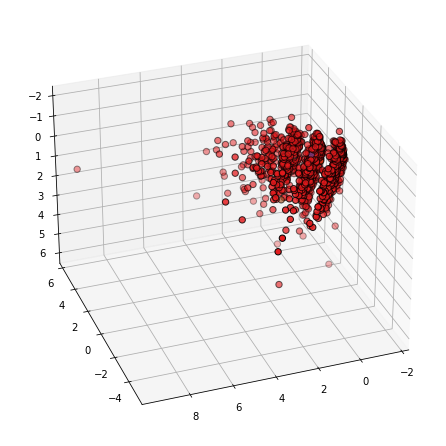

In [60]:
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.decomposition import PCA   #降維度   

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(TF_matrix.values)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=dbscan.labels_,
          cmap=plt.cm.Set1, edgecolor='k', s=40)

In [61]:
cluster_results = dbscan.labels_
for cluster in set(cluster_results):
    members = []
    for i in range(len(cluster_results)):
        if cluster_results[i] == cluster:
            members.append(doc_IDs[i])
    clusters[cluster] = members

In [62]:
# feature selection (to understand the cluster(topic) through important terms)

# pointwise mutual information

def term_count_PMI(counttc, ptc, pt, pc):
    PMI = np.log2(ptc / (pt * pc))
    return counttc * PMI

cluster_terms = {}

for cluster in clusters:
    
    scores = []
    
    # calculate probability of cluster
    pc = len(clusters[cluster]) / len(doc_IDs)
    
    for t in terms:
        
        # calculate count of term t in cluster
        counttc = 0
        for member in clusters[cluster]:
            terms_of_member = new_df3[new_df3['docID'] == member].term.values
            if t in terms_of_member:
                counttc += new_df3[(new_df3['docID'] == member) & (new_df3['term'] == t)].tf.values[0]
        
        if counttc == 0:
            scores.append(0)
        
        else:
            
            # calculate probability of term t in cluster
            ptc = 0
            n = 0
            for member in clusters[cluster]:
                if t in new_df3[new_df3['docID'] == member].term.values:
                    n += 1
            ptc = n/len(doc_IDs)

            # calculate probability of term t
            pt = len(set(new_df3[new_df3['term'] == t].docID.values)) / len(doc_IDs)

            # calcuate count * PMI
            scores.append(term_count_PMI(counttc, ptc, pt, pc))
    
    # find 10 terms with largest score
    cluster_terms[cluster] = [terms[i] for i in np.argsort(scores)[-10:]]

In [63]:
for topic in cluster_terms:
    print('Topic ' + str(topic) + ':')
    print(cluster_terms[topic], '\n')

Topic 0:
['management', 'best', 'friendly', 'nice', 'life', 'balance', 'great', 'place', 'work', 'good'] 

Topic 1:
['welcome', 'achivement', 'price', 'plan', 'best', 'pru', 'prudential', 'insurance', 'product', 'icici'] 

Topic 2:
['foundation', 'learned', 'compulsory', 'methodologies', 'bus', 'ambigious', 'visual', 'completed', 'manual', 'testing'] 

Topic 3:
['generally', 'benefits', 'permits', 'instance', 'great', 'managers', 'approachable', 'guidance', 'engagements', 'kind'] 

Topic 4:
['denied', 'extreme', 'unsupportive', 'bais', 'memo', 'disrespect', 'demise', 'family', 'even', 'leaves'] 

Topic 5:
['secured', 'automation', 'mumbai', 'unless', 'management', 'ruined', 'unfriendly', 'forced', 'basically', 'worst'] 

Topic 6:
['ability', 'materials', 'quick', 'training', 'video', 'tutorials', 'awarness', 'learn', 'online', 'programms'] 

Topic 7:
['shifts', 'language', 'sla', 'management', 'barrier', 'reasons', 'goa', 'want', 'chennai', 'relocate'] 

Topic 8:
['pleasant', 'improved

# 找評論面向：SVD

In [64]:
# SVD (10 個 topic)

from sklearn.decomposition import TruncatedSVD

model_SVD = TruncatedSVD(n_components = 10)
vectors_SVD = model_SVD.fit_transform(normalized_TFIDF_matrix)

In [65]:
vectors_SVD

array([[ 0.15236508, -0.02999594,  0.10994598, ...,  0.0118458 ,
         0.0442833 ,  0.01345789],
       [ 0.15132058,  0.0300715 ,  0.08424238, ...,  0.00785429,
        -0.03321463, -0.06741745],
       [ 0.23845633, -0.17076566,  0.04593912, ...,  0.03322007,
         0.06261393,  0.11406244],
       ...,
       [ 0.0932965 ,  0.1260583 , -0.06336584, ...,  0.0865571 ,
        -0.11610345,  0.0662633 ],
       [ 0.20871889,  0.29053955, -0.13700644, ...,  0.03503566,
         0.06534406, -0.02067336],
       [ 0.25667038, -0.21187114,  0.23120386, ...,  0.14414716,
         0.27321084,  0.07128998]])

In [66]:
# Topics
for i in range(len(model_SVD.components_)):
    scores = model_SVD.components_[i]
    important_terms = [terms[i] for i in np.argsort(abs(scores))[-10:]]
    print('Topic ' + str(i) + ':')
    print(important_terms, '\n')

Topic 0:
['life', 'environment', 'job', 'culture', 'management', 'great', 'place', 'company', 'work', 'good'] 

Topic 1:
['job', 'balance', 'enjoyable', 'place', 'day', 'great', 'workers', 'learned', 'co', 'part'] 

Topic 2:
['company', 'great', 'part', 'lot', 'job', 'life', 'balance', 'new', 'learn', 'things'] 

Topic 3:
['bank', 'learning', 'part', 'nice', 'also', 'opportunities', 'company', 'best', 'place', 'great'] 

Topic 4:
['working', 'one', 'balance', 'life', 'good', 'place', 'company', 'best', 'environment', 'nice'] 

Topic 5:
['hgs', 'security', 'things', 'new', 'balance', 'life', 'learn', 'good', 'best', 'great'] 

Topic 6:
['part', 'life', 'growth', 'learn', 'great', 'working', 'new', 'company', 'learned', 'lot'] 

Topic 7:
['experience', 'friendly', 'lot', 'co', 'workers', 'learned', 'project', 'best', 'place', 'team'] 

Topic 8:
['balance', 'also', 'hgs', 'good', 'bank', 'new', 'environment', 'nice', 'tcs', 'job'] 

Topic 9:
['tcs', 'time', 'get', 'axis', 'nice', 'growth'

In [67]:
# SVD (5 個 topic)

from sklearn.decomposition import TruncatedSVD

model_SVD = TruncatedSVD(n_components = 5)
vectors_SVD = model_SVD.fit_transform(normalized_TFIDF_matrix)

In [68]:
vectors_SVD

array([[ 0.15236628, -0.03126066,  0.11056009,  0.03123429, -0.05626035],
       [ 0.15132056,  0.02733757,  0.08158317, -0.03357356, -0.00792371],
       [ 0.23845135, -0.17392443,  0.04664797, -0.10306361, -0.02341516],
       ...,
       [ 0.09329625,  0.12469212, -0.07015166,  0.06376009,  0.05875658],
       [ 0.20872031,  0.29032836, -0.13727121,  0.1093824 , -0.02777386],
       [ 0.25667101, -0.21297443,  0.23486715,  0.16874651, -0.12610884]])

In [69]:
# Topics
for i in range(len(model_SVD.components_)):
    scores = model_SVD.components_[i]
    important_terms = [terms[i] for i in np.argsort(abs(scores))[-10:]]
    print('Topic ' + str(i) + ':')
    print(important_terms, '\n')

Topic 0:
['life', 'environment', 'job', 'culture', 'management', 'great', 'place', 'company', 'work', 'good'] 

Topic 1:
['job', 'balance', 'enjoyable', 'place', 'great', 'day', 'workers', 'learned', 'part', 'co'] 

Topic 2:
['company', 'great', 'part', 'lot', 'job', 'life', 'balance', 'new', 'learn', 'things'] 

Topic 3:
['learning', 'workers', 'nice', 'also', 'co', 'opportunities', 'company', 'best', 'place', 'great'] 

Topic 4:
['balance', 'working', 'team', 'good', 'life', 'company', 'place', 'best', 'environment', 'nice'] 



# 找評論面向：LDA

In [70]:
# 轉成 TF 向量

TF_matrix = pd.DataFrame(columns = terms, index = doc_IDs)

for i in doc_IDs:
    
    terms_of_docID = new_df3[new_df3['docID'] == i].term.values
    
    for t in terms:
        if t not in terms_of_docID:
            TF_matrix.at[i, t] = 0
        else:
            TF_matrix.at[i, t] = new_df3[(new_df3['docID'] == i) & (new_df3['term'] == t)].tf.values[0]


In [71]:
# LDA (10 個 topic)

from sklearn.decomposition import LatentDirichletAllocation as LDA

model_LDA = LDA(n_components = 10)
vectors_LDA = model_LDA.fit_transform(TF_matrix)

In [72]:
vectors_LDA

array([[0.0032263 , 0.00322687, 0.61773412, ..., 0.0032267 , 0.00322658,
        0.00322603],
       [0.00285761, 0.39761019, 0.00285807, ..., 0.00285749, 0.00285773,
        0.00285785],
       [0.00454632, 0.00454651, 0.57432416, ..., 0.0045457 , 0.38930674,
        0.00454613],
       ...,
       [0.00909166, 0.81987752, 0.00909299, ..., 0.10738494, 0.00909257,
        0.00909191],
       [0.00416702, 0.77788086, 0.00416787, ..., 0.00416732, 0.00416756,
        0.0041674 ],
       [0.00909191, 0.00909234, 0.42301343, ..., 0.00909281, 0.5042491 ,
        0.00909166]])

In [73]:
# Topics
for i in range(len(model_LDA.components_)):
    scores = model_LDA.components_[i]
    important_terms = [terms[i] for i in np.argsort(abs(scores))[-10:]]
    print('Topic ' + str(i) + ':')
    print(important_terms, '\n')

Topic 0:
['learning', 'one', 'process', 'life', 'learn', 'work', 'also', 'management', 'company', 'good'] 

Topic 1:
['workers', 'co', 'culture', 'company', 'working', 'part', 'job', 'management', 'work', 'good'] 

Topic 2:
['culture', 'learn', 'management', 'life', 'working', 'company', 'place', 'great', 'good', 'work'] 

Topic 3:
['experience', 'job', 'working', 'process', 'like', 'learned', 'one', 'lot', 'work', 'company'] 

Topic 4:
['company', 'learned', 'learning', 'day', 'best', 'part', 'time', 'management', 'team', 'work'] 

Topic 5:
['payroll', 'good', 'management', 'gud', 'co', 'many', 'learned', 'testing', 'working', 'team'] 

Topic 6:
['wish', 'hi', 'employees', 'experience', 'thank', 'best', 'work', 'hgs', 'team', 'good'] 

Topic 7:
['system', 'work', 'process', 'campaign', 'day', 'different', 'people', 'enjoyable', 'part', 'job'] 

Topic 8:
['best', 'experience', 'people', 'one', 'place', 'new', 'career', 'company', 'good', 'work'] 

Topic 9:
['friendly', 'different', 'cu

In [74]:
# LDA (5 個 topic)

from sklearn.decomposition import LatentDirichletAllocation as LDA

model_LDA = LDA(n_components = 5)
vectors_LDA = model_LDA.fit_transform(TF_matrix)

In [75]:
vectors_LDA

array([[0.37469362, 0.00654709, 0.00655047, 0.60566428, 0.00654453],
       [0.00584637, 0.25831179, 0.00581159, 0.7241721 , 0.00585815],
       [0.063876  , 0.00916734, 0.00910651, 0.9086921 , 0.00915805],
       ...,
       [0.01837401, 0.01824931, 0.01826349, 0.01896009, 0.92615309],
       [0.00848835, 0.00843005, 0.00837208, 0.60739606, 0.36731347],
       [0.0183758 , 0.01827137, 0.01818807, 0.9268799 , 0.01828485]])

In [76]:
# Topics
for i in range(len(model_LDA.components_)):
    scores = model_LDA.components_[i]
    important_terms = [terms[i] for i in np.argsort(abs(scores))[-10:]]
    print('Topic ' + str(i) + ':')
    print(important_terms, '\n')

Topic 0:
['different', 'company', 'projects', 'learning', 'employees', 'new', 'management', 'time', 'good', 'team'] 

Topic 1:
['business', 'one', 'years', 'experience', 'banking', 'company', 'hdfc', 'employees', 'management', 'bank'] 

Topic 2:
['experience', 'customers', 'daily', 'hi', 'handling', 'process', 'team', 'customer', 'hgs', 'management'] 

Topic 3:
['life', 'environment', 'culture', 'working', 'great', 'place', 'management', 'company', 'good', 'work'] 

Topic 4:
['new', 'workers', 'day', 'working', 'co', 'enjoyable', 'learned', 'job', 'work', 'part'] 

